# Steady-state Finder

This is an example of how to use an internal MOOSE solver to find steady
states of a system very rapidly. The method starts from a random position
in state space that obeys mass conservation. It then finds the nearest
steady state and reports it. If it does this enough times it should find
all the steady states. 

We illustrate this process for 50 attempts to find the steady states.
It does find all of them. Each time it plots and prints the values, though
the plotting is not necessary.

The printout shows the concentrations of all molecules in the first 5 columns.
Then it prints the type of solution, and the numbers of negative and positive 
eigenvalues. In all cases the calculations are successful, though it takes
different numbers of iterations to arrive at the steady state. In some models
it would be necessary to put a cap on the number of iterations, if the 
system is not able to find a steady state.

In this example we run the bistable model using the ODE solver right at 
the end, and manually enforce transitions to show where the target steady 
states are.

For more information on the algorithm used, look in the comments within the main method of the code below. 

0.92 0.05 0.00 0.01 0.01 Type=2 NegEig=2 PosEig=1 status=0 success Iter=16
0.92 0.05 0.00 0.01 0.01 Type=2 NegEig=2 PosEig=1 status=0 success Iter=29
0.18 0.75 0.00 0.03 0.01 Type=0 NegEig=3 PosEig=0 status=0 success Iter=10
0.18 0.75 0.00 0.03 0.01 Type=0 NegEig=3 PosEig=0 status=0 success Iter=26
0.18 0.75 0.00 0.03 0.01 Type=0 NegEig=3 PosEig=0 status=0 success Iter=27
0.92 0.05 0.00 0.01 0.01 Type=2 NegEig=2 PosEig=1 status=0 success Iter=30
0.18 0.75 0.00 0.03 0.01 Type=0 NegEig=3 PosEig=0 status=0 success Iter=12
0.92 0.05 0.00 0.01 0.01 Type=2 NegEig=2 PosEig=1 status=0 success Iter=29
0.18 0.75 0.00 0.03 0.01 Type=0 NegEig=3 PosEig=0 status=0 success Iter=12
0.92 0.05 0.00 0.01 0.01 Type=2 NegEig=2 PosEig=1 status=0 success Iter=41
0.18 0.75 0.00 0.03 0.01 Type=0 NegEig=3 PosEig=0 status=0 success Iter=29
0.18 0.75 0.00 0.03 0.01 Type=0 NegEig=3 PosEig=0 status=0 success Iter=18
0.18 0.75 0.00 0.03 0.01 Type=0 NegEig=3 PosEig=0 status=0 success Iter=27
0.18 0.75 0.00 0.03 0.01 

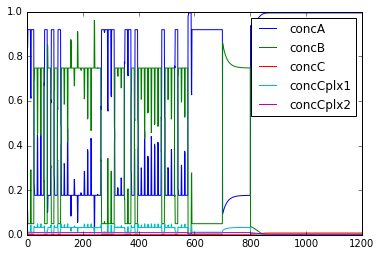

In [1]:
#########################################################################
## This program is part of 'MOOSE', the
## Messaging Object Oriented Simulation Environment.
##           Copyright (C) 2013 Upinder S. Bhalla. and NCBS
## It is made available under the terms of the
## GNU Lesser General Public License version 2.1
## See the file COPYING.LIB for the full notice.
#########################################################################

from __future__ import print_function

%matplotlib inline

import math
import pylab
import numpy
import moose

def main():
    """
    This example sets up the kinetic solver and steady-state finder, on
    a bistable model of a chemical system. The model is set up within the
    script.
    The algorithm calls the steady-state finder 50 times with different
    (randomized) initial conditions, as follows:

    * Set up the random initial condition that fits the conservation laws
    * Run for 2 seconds. This should not be mathematically necessary, but
      for obscure numerical reasons it makes it much more likely that the
      steady state solver will succeed in finding a state.
    * Find the fixed point
    * Print out the fixed point vector and various diagnostics.
    * Run for 10 seconds. This is completely unnecessary, and is done here
      just so that the resultant graph will show what kind of state has
      been  found.

    After it does all this, the program runs for 100 more seconds on the
    last found fixed point (which turns out to be a saddle node), then
    is hard-switched in the script to the first attractor basin from which
    it runs for another 100 seconds till it settles there, and then
    is hard-switched yet again to the second attractor and runs for 400
    seconds.

    Looking at the output you will see many features of note:

    * the first attractor (stable point) and the saddle point (unstable
      fixed point) are both found quite often. But the second
      attractor is found just once.
      It has a very small basin of attraction.
    * The values found for each of the fixed points match well with the
      values found by running the system to steady-state at the end.
    * There are a large number of failures to find a fixed point. These are
      found and reported in the diagnostics. They show up on the plot
      as cases where the 10-second runs are not flat.

    If you wanted to find fixed points in a production model, you would
    not need to do the 10-second runs, and you would need to eliminate the
    cases where the state-finder failed. Then you could identify the good
    points and keep track of how many of each were found.

    There is no way to guarantee that all fixed points have been found
    using this algorithm! If there are points in an obscure corner of state
    space (as for the singleton second attractor convergence in this
    example) you may have to iterate very many times to find them.

    You may wish to sample concentration space logarithmically rather than
    linearly.
    """
    compartment = makeModel()
    ksolve = moose.Ksolve( '/model/compartment/ksolve' )
    stoich = moose.Stoich( '/model/compartment/stoich' )
    stoich.compartment = compartment
    stoich.ksolve = ksolve
    stoich.path = "/model/compartment/##"
    state = moose.SteadyState( '/model/compartment/state' )

    moose.reinit()
    state.stoich = stoich
    state.showMatrices()
    state.convergenceCriterion = 1e-6
    moose.seed( 111 ) # Used when generating the samples in state space

    for i in range( 0, 50 ):
        getState( ksolve, state )

    # Now display the states of the system at more length to compare.
    moose.start( 100.0 ) # Run the model for 100 seconds.

    a = moose.element( '/model/compartment/a' )
    b = moose.element( '/model/compartment/b' )

    # move most molecules over to b
    b.conc = b.conc + a.conc * 0.9
    a.conc = a.conc * 0.1
    moose.start( 100.0 ) # Run the model for 100 seconds.

    # move most molecules back to a
    a.conc = a.conc + b.conc * 0.99
    b.conc = b.conc * 0.01
    moose.start( 400.0 ) # Run the model for 200 seconds.

    # Iterate through all plots, dump their contents to data.plot.
    displayPlots()

    quit()

def makeModel():
    """ This function creates a bistable reaction system using explicit
    MOOSE calls rather than load from a file
    """
    # create container for model
    model = moose.Neutral( 'model' )
    compartment = moose.CubeMesh( '/model/compartment' )
    compartment.volume = 1e-15
    # the mesh is created automatically by the compartment
    mesh = moose.element( '/model/compartment/mesh' )

    # create molecules and reactions
    a = moose.Pool( '/model/compartment/a' )
    b = moose.Pool( '/model/compartment/b' )
    c = moose.Pool( '/model/compartment/c' )
    enz1 = moose.Enz( '/model/compartment/b/enz1' )
    enz2 = moose.Enz( '/model/compartment/c/enz2' )
    cplx1 = moose.Pool( '/model/compartment/b/enz1/cplx' )
    cplx2 = moose.Pool( '/model/compartment/c/enz2/cplx' )
    reac = moose.Reac( '/model/compartment/reac' )

    # connect them up for reactions
    moose.connect( enz1, 'sub', a, 'reac' )
    moose.connect( enz1, 'prd', b, 'reac' )
    moose.connect( enz1, 'enz', b, 'reac' )
    moose.connect( enz1, 'cplx', cplx1, 'reac' )

    moose.connect( enz2, 'sub', b, 'reac' )
    moose.connect( enz2, 'prd', a, 'reac' )
    moose.connect( enz2, 'enz', c, 'reac' )
    moose.connect( enz2, 'cplx', cplx2, 'reac' )

    moose.connect( reac, 'sub', a, 'reac' )
    moose.connect( reac, 'prd', b, 'reac' )

    # Assign parameters
    a.concInit = 1
    b.concInit = 0
    c.concInit = 0.01
    enz1.kcat = 0.4
    enz1.Km = 4
    enz2.kcat = 0.6
    enz2.Km = 0.01
    reac.Kf = 0.001
    reac.Kb = 0.01

    # Create the output tables
    graphs = moose.Neutral( '/model/graphs' )
    outputA = moose.Table2 ( '/model/graphs/concA' )
    outputB = moose.Table2 ( '/model/graphs/concB' )
    outputC = moose.Table2 ( '/model/graphs/concC' )
    outputCplx1 = moose.Table2 ( '/model/graphs/concCplx1' )
    outputCplx2 = moose.Table2 ( '/model/graphs/concCplx2' )

    # connect up the tables
    moose.connect( outputA, 'requestOut', a, 'getConc' );
    moose.connect( outputB, 'requestOut', b, 'getConc' );
    moose.connect( outputC, 'requestOut', c, 'getConc' );
    moose.connect( outputCplx1, 'requestOut', cplx1, 'getConc' );
    moose.connect( outputCplx2, 'requestOut', cplx2, 'getConc' );

    return compartment

def displayPlots():
    for x in moose.wildcardFind( '/model/graphs/conc#' ):
            t = numpy.arange( 0, x.vector.size, 1 ) #sec
            pylab.plot( t, x.vector, label=x.name )
    pylab.legend()
    pylab.show()

def getState( ksolve, state ):
    """ This function finds a steady state starting from a random
    initial condition that is consistent with the stoichiometry rules
    and the original model concentrations.
    """
    scale = 1.0 / ( 1e-15 * 6.022e23 )
    state.randomInit() # Randomize init conditions, subject to stoichiometry
    moose.start( 2.0 ) # Run the model for 2 seconds.
    state.settle() # This function finds the steady states.
    for x in ksolve.nVec[0]:
        print( "{:.2f}".format( x * scale ), end=' ')

    print( "Type={} NegEig={} PosEig={} status={} {} Iter={:2d}".format( state.stateType, state.nNegEigenvalues, state.nPosEigenvalues, state.solutionStatus, state.status, state.nIter))
    moose.start( 10.0 ) # Run model for 10 seconds, just for display


# Run the 'main' if this script is executed standalone.
if __name__ == '__main__':
    main()